<a href="https://colab.research.google.com/github/AshnakAGQ/DistractedDriver/blob/master/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

##Tensorflow

In [0]:
!pip install tf-nightly
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Sequential
import matplotlib.pyplot as plt

In [0]:
print(tf.__version__)

2.3.0-dev20200610


##Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


##Kaggle

In [0]:
!pip install kaggle
import os # Sets the environment variables in the root folder 
os.environ['KAGGLE_USERNAME'] = "unorna"
os.environ['KAGGLE_KEY'] = "0a21e3dad74e374d7054ac533a76ede3"
import kaggle
kaggle.api.authenticate()
kaggle.api.competition_download_files('state-farm-distracted-driver-detection', path = 'data/DistractedDriver')
!unzip -q data/DistractedDriver/state-farm-distracted-driver-detection.zip  #unzips kaggle data into content/data

#Import image data


In [0]:
image_size = (224, 224) #image size for image net is 224 x 224 x 3
batch_size = 32

full_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "imgs/train",
    image_size = image_size,
    batch_size = batch_size,
    shuffle = False
)

full_ds_s = tf.keras.preprocessing.image_dataset_from_directory(
    "imgs/train",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True
)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "imgs/train",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
    subset = 'training',
    validation_split = 0.2,
    shuffle = True
).prefetch(tf.data.experimental.AUTOTUNE)

validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "imgs/train",
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
    subset = 'validation',
    validation_split = 0.2,
    shuffle = True
).prefetch(tf.data.experimental.AUTOTUNE)

Found 22424 files belonging to 10 classes.
Found 22424 files belonging to 10 classes.
Found 22424 files belonging to 10 classes.
Using 17940 files for training.
Found 22424 files belonging to 10 classes.
Using 4484 files for validation.


##View Data

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in full_ds_s.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

#Cross-Validation

In [0]:
def crossvalidate(dataset, n_splits, batch_size=32, seed=0):

  """
  Given a dataset, splits it into {n_splits} subsets, where for 
  any given index, train_ds[i] contains all the subsets except 
  the portion in val_ds[i]

  Parameters
  ----------
  dataset : tensorflow.data.dataset
      Full dataset to split
    
  n_splits : int
      Number of splits; XFold # (at least 2 or greater)
      
  Returns
  -------
  train_ds : list (dtype=ConcatenateDataset)
      List of datasets not containing the ith portion of data
      
  val_ds : list (dtype=ShardDataset)
      List of datasets containing the ith portion of data
  
  """

  # Initialize lists
  val_ds = []
  train_ds = []

  # Create val_ds first
  for i in range(n_splits):
    val_ds.append(dataset.shard(num_shards=n_splits, index=i).shuffle(buffer_size=batch_size * 8, seed=seed))

  # Create train_ds using val_ds indexes other than the current index
  for i in range(n_splits):
    if i == 0:
      train_ds.append(val_ds[1])
    else:
      train_ds.append(val_ds[0])
    for a in range(1, i):
      train_ds[i] = train_ds[i].concatenate(val_ds[a].shuffle(buffer_size=batch_size * 8, seed=seed))
    for b in range(i+1, n_splits):
      if not(i==0 and b==1):
        train_ds[i] = train_ds[i].concatenate(val_ds[b].shuffle(buffer_size=batch_size * 8, seed=seed))

  return train_ds, val_ds

In [0]:
n_splits = 5

cv_training_ds, cv_val_ds = crossvalidate(full_ds, n_splits, seed=1337)

"""# Set up prefetching
for i in range(len(cv_training_ds)):m
  cv_training_ds[i] = cv_training_ds[i].prefetch(tf.data.experimental.AUTOTUNE)
  cv_val_ds[i] = cv_val_ds[i].prefetch(tf.data.experimental.AUTOTUNE)
"""
print(len(cv_training_ds), cv_training_ds[0])
print(len(cv_val_ds), cv_val_ds[0])

print(tf.data.experimental.cardinality(full_ds))
print(tf.data.experimental.cardinality(cv_training_ds[1]))
print(tf.data.experimental.cardinality(train_ds))
print(tf.data.experimental.cardinality(cv_val_ds[1]))
print(tf.data.experimental.cardinality(validation_ds))

In [0]:
"""import time
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()

    model = VGG16(include_top=False,weights='imagenet', input_shape=(320,240,3))
    flatten = Flatten()(model.outputs[-1])
    output = Dense(10, activation = 'softmax')(flatten)
    model = Model(inputs=model.inputs,outputs=output)

    # Might have to copy data from Google Drive to the Google Environment
    model.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
    model.fit(dataset, epochs=10)

    # Generate generalization metrics
    scores = model.evaluate(dataset, verbose=0)
    
    tf.print("Execution time:", time.perf_counter() - start_time)"""

In [0]:
import numpy as np

for images, labels in full_ds_s.take(1):
  print(images)

In [0]:
# batch size = 32
#benchmark(cv_val_ds[0])

In [0]:
# batch size = 32
#benchmark(cv_val_ds[0].prefetch(tf.data.experimental.AUTOTUNE))

In [0]:
# batch size = 128
#benchmark(cv_val_ds[0].prefetch(tf.data.experimental.AUTOTUNE))

#Model Testing

In [0]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode ='min', patience=4),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True)
]
inception_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode ='min', patience=4),
    tf.keras.callbacks.ModelCheckpoint(filepath='inceptionmodel.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True)
]

resnet_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss',mode ='auto', patience=4),
    tf.keras.callbacks.ModelCheckpoint(filepath='resnet.{epoch:02d}-{loss:.2f}.h5', save_best_only=True)

]

##VGG16

###Summary

In [0]:
VGGnet = VGG16(include_top=False, weights = "imagenet", input_shape=(224, 224, 3))
flatten = Flatten()(VGGnet.outputs[-1])
VGGnet = Model(inputs=VGGnet.inputs,outputs=flatten)
vgg_model = Sequential()
vgg_model.add(VGGnet)
vgg_model.add(Dense(4096, activation='relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(4096, activation='relu'))
vgg_model.add(Dropout(0.3))
vgg_model.add(Dense(10, activation='softmax'))
#model = VGG16(include_top=False,weights='imagenet', input_shape=(224,224,3))
#flatten = Flatten()(model.outputs[-1])
#output = Dense(10, activation = 'softmax')(flatten)
#model = Model(inputs=model.inputs,outputs=output)
vgg_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_7 (Functional)    (None, 25088)             14714688  
_________________________________________________________________
dense_9 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dropout_6 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dropout_7 (Dropout)          (None, 4096)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                40970     
Total params: 134,301,514
Trainable params: 134,301,514
Non-trainable params: 0
________________________________________

In [0]:
frozen_VGGnet = VGG16(include_top=False, weights = "imagenet", input_shape=(224, 224, 3))
for layers in frozen_VGGnet.layers:
  layers.trainable = False
frozen_flatten = Flatten()(frozen_VGGnet.outputs[-1])
frozen_VGGnet = Model(inputs=frozen_VGGnet.inputs,outputs=frozen_flatten)
frozen_vgg_model = Sequential()
frozen_vgg_model.add(frozen_VGGnet)
frozen_vgg_model.add(Dense(4096, activation='relu'))
frozen_vgg_model.add(Dropout(0.3))
frozen_vgg_model.add(Dense(4096, activation='relu'))
frozen_vgg_model.add(Dropout(0.3))
frozen_vgg_model.add(Dense(10, activation='softmax'))

In [0]:
# model.save_weights('drive/My Drive/my_model_weights.h5') # Save the current model into Google Drive

###Testing

In [0]:
def VGG_preprocess(image,score):
  image = keras.applications.vgg16.preprocess_input(image)
  if score is None:
        return image
  else:
        return image, score



In [0]:
train = full_ds_s.map(VGG_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train = train.prefetch(tf.data.experimental.AUTOTUNE)

vgg_model.compile(optimizer=keras.optimizers.SGD(lr=0.001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
unfrozen_vgg_history = vgg_model.fit(train, epochs=10)

Epoch 1/10
701/701 [==============================] - 159s 227ms/step - loss: 1.5910 - accuracy: 0.4331
Epoch 2/10
701/701 [==============================] - 159s 227ms/step - loss: 0.1425 - accuracy: 0.9571
Epoch 3/10
701/701 [==============================] - 159s 227ms/step - loss: 0.0413 - accuracy: 0.9883
Epoch 4/10
701/701 [==============================] - 159s 227ms/step - loss: 0.0222 - accuracy: 0.9935
Epoch 5/10
701/701 [==============================] - 159s 227ms/step - loss: 0.0130 - accuracy: 0.9962
Epoch 6/10
701/701 [==============================] - 159s 227ms/step - loss: 0.0071 - accuracy: 0.9985
Epoch 7/10
701/701 [==============================] - 159s 227ms/step - loss: 0.0069 - accuracy: 0.9982
Epoch 8/10
701/701 [==============================] - 159s 227ms/step - loss: 0.0045 - accuracy: 0.9985
Epoch 9/10
701/701 [==============================] - 159s 227ms/step - loss: 0.0022 - accuracy: 0.9995
Epoch 10/10
701/701 [==============================] - 159s 227m

In [0]:
train = full_ds_s.map(VGG_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train = train.prefetch(tf.data.experimental.AUTOTUNE)

frozen_vgg_model.compile(optimizer=keras.optimizers.SGD(lr=0.001), loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
frozen_vgg_history = frozen_vgg_model.fit(train, epochs=10)

Epoch 1/10
701/701 [==============================] - 104s 149ms/step - loss: 1.7867 - accuracy: 0.8611
Epoch 2/10
701/701 [==============================] - 102s 146ms/step - loss: 0.1006 - accuracy: 0.9756
Epoch 3/10
701/701 [==============================] - 103s 146ms/step - loss: 0.0401 - accuracy: 0.9893
Epoch 4/10
701/701 [==============================] - 103s 146ms/step - loss: 0.0262 - accuracy: 0.9928
Epoch 5/10
701/701 [==============================] - 103s 147ms/step - loss: 0.0194 - accuracy: 0.9940
Epoch 6/10
701/701 [==============================] - 103s 147ms/step - loss: 0.0152 - accuracy: 0.9953
Epoch 7/10
701/701 [==============================] - 103s 147ms/step - loss: 0.0103 - accuracy: 0.9971
Epoch 8/10
701/701 [==============================] - 103s 146ms/step - loss: 0.0082 - accuracy: 0.9972
Epoch 9/10
701/701 [==============================] - 102s 146ms/step - loss: 0.0079 - accuracy: 0.9975
Epoch 10/10
701/701 [==============================] - 102s 146m

In [0]:

accuracies = []
losses = []

for i in range(len(cv_training_ds)):

  # Pre-processing
  train = cv_training_ds[i].map(VGG_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  train = train.prefetch(tf.data.experimental.AUTOTUNE)
  val = cv_val_ds[i].map(VGG_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
  val = val.prefetch(tf.data.experimental.AUTOTUNE)

  model = VGG16(include_top=True, weights = None, classes = 10, input_shape=(224, 224, 3))
  #model = VGG16(include_top=False, classes = 10, input_shape=(320,240,3))
  #flatten = Flatten()(model.outputs[-1])
  #output = Dense(10, activation = 'softmax')(flatten)
  #model = Model(inputs=model.inputs,outputs=output)

  # Might have to copy data from Google Drive to the Google Environment
  model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
  model.fit(train, epochs=10, validation_data=val, callbacks=my_callbacks)

  # Generate generalization metrics
  scores = model.evaluate(val, verbose=0)
  accuracies.append(scores[1] * 100)
  losses.append(scores[0])

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracies)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {losses[i]} - Accuracy: {accuracies[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracies)} (+- {np.std(accuracies)})')
print(f'> Loss: {np.mean(losses)}')
print('------------------------------------------------------------------------')

### Summary

In [0]:
unfrozen_vgg_history.history

{'accuracy': [0.4331073760986328,
  0.9571441411972046,
  0.9882714748382568,
  0.993533730506897,
  0.996209442615509,
  0.9984837770462036,
  0.9982162117958069,
  0.9985283613204956,
  0.9994648694992065,
  0.9989297389984131],
 'loss': [1.5909792184829712,
  0.1425061821937561,
  0.04129762575030327,
  0.02215718850493431,
  0.012991468422114849,
  0.007085103541612625,
  0.00692301569506526,
  0.004514207132160664,
  0.0022130031138658524,
  0.0029658207204192877]}

In [0]:
frozen_vgg_history.history

{'accuracy': [0.8610863089561462,
  0.9755619168281555,
  0.9892972111701965,
  0.9928202033042908,
  0.9940242767333984,
  0.9953175187110901,
  0.9970567226409912,
  0.997235119342804,
  0.9975026845932007,
  0.997190535068512],
 'loss': [1.7866548299789429,
  0.10057111084461212,
  0.04011673480272293,
  0.02623715251684189,
  0.019368525594472885,
  0.015210644342005253,
  0.01033426821231842,
  0.00824557151645422,
  0.007892129942774773,
  0.0073973312973976135]}

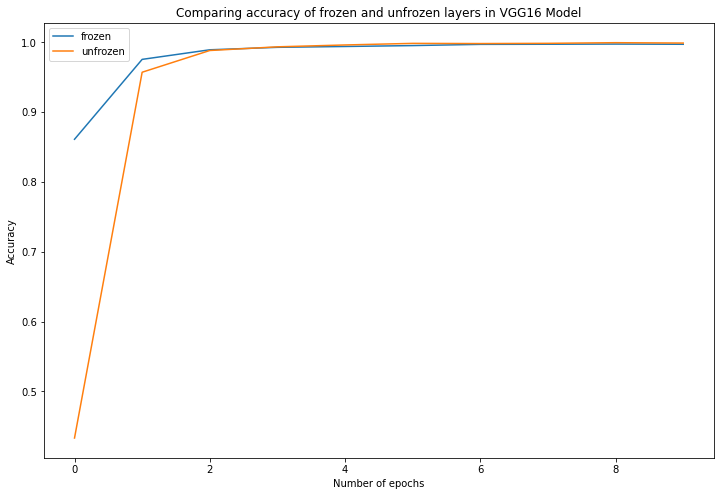

In [0]:
plt.figure(figsize=(12,8))
plt.plot(frozen_vgg_history.history['accuracy'])
plt.plot(unfrozen_vgg_history.history['accuracy'])
plt.title("Comparing accuracy of frozen and unfrozen layers in VGG16 Model")
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend(['frozen','unfrozen'], loc='upper left')

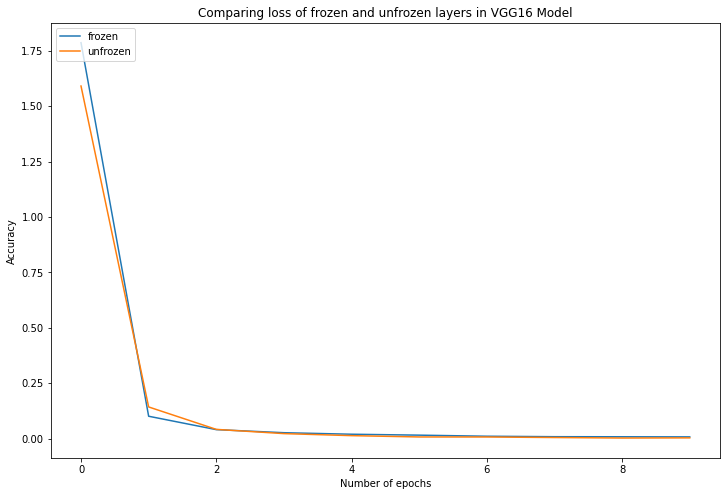

In [0]:
plt.figure(figsize=(12,8))
plt.plot(frozen_vgg_history.history['loss'])
plt.plot(unfrozen_vgg_history.history['loss'])
plt.title("Comparing loss of frozen and unfrozen layers in VGG16 Model")
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend(['frozen','unfrozen'], loc='upper left')

In [0]:
vgg_model.save("drive/My Drive/unfrozen_vgg16_model.h5")
frozen_vgg_model.save("drive/My Drive/frozen_vgg16_model.h5")

##Resnet

###Summary

In [0]:
resnet_model = ResNet50(include_top =True,weights='imagenet', input_shape=(224,224,3))
resnet_output= Flatten()(resnet_model.outputs[-1])
resnet_model = Model(inputs=resnet_model.inputs,outputs=resnet_output)
resnet_edited = tf.keras.Sequential()
resnet_edited.add(resnet_model)
resnet_edited.add(Dense(4096, activation='relu'))
resnet_edited.add(tf.keras.layers.Dropout(0.3))
resnet_edited.add(Dense(4096, activation='relu'))
resnet_edited.add(tf.keras.layers.Dropout(0.3))
resnet_edited.add(Dense(10, activation='softmax'))

###Testing

In [0]:
accuracies = []
losses = []

for i in range(len(cv_training_ds)):
  resnet_model = ResNet50(include_top =False,weights='imagenet', input_shape=(320,240,3))
  resnet_flatten = Flatten()(resnet_model.outputs[-1])
  resnet_output = Dense(10, activation = 'softmax')(resnet_flatten)
  resnet_model = Model(inputs=resnet_model.inputs,outputs=resnet_output)
  
  resnet_model.compile(optimizer='nadam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
  resnet_model.fit(cv_training_ds[i], epochs=10, validation_data=cv_val_ds[i], callbacks=my_callbacks)

  # Generate generalization metrics
  scores = resnet_model.evaluate(cv_val_ds[i], verbose=0)
  accuracies.append(scores[1] * 100)
  losses.append(scores[0])

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracies)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {losses[i]} - Accuracy: {accuracies[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracies)} (+- {np.std(accuracies)})')
print(f'> Loss: {np.mean(losses)}')
print('------------------------------------------------------------------------')

In [0]:
def Resnet_preprocess(image,score):
  image = keras.applications.resnet50.preprocess_input(image)
  if score is None:
        return image
  else:
        return image, score
train = full_ds_s.map(Resnet_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train = train.prefetch(tf.data.experimental.AUTOTUNE)

resnet_edited.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
unfrozen_resnet_history = resnet_edited.fit(train, epochs=10)


Epoch 1/10
701/701 [==============================] - 129s 185ms/step - loss: 1.3623 - accuracy: 0.4580
Epoch 2/10
701/701 [==============================] - 129s 184ms/step - loss: 0.3865 - accuracy: 0.8828
Epoch 3/10
701/701 [==============================] - 128s 183ms/step - loss: 0.3746 - accuracy: 0.8965
Epoch 4/10
701/701 [==============================] - 128s 183ms/step - loss: 0.2225 - accuracy: 0.9402
Epoch 5/10
701/701 [==============================] - 129s 184ms/step - loss: 0.1243 - accuracy: 0.9696
Epoch 6/10
701/701 [==============================] - 129s 183ms/step - loss: 0.1214 - accuracy: 0.9691
Epoch 7/10
701/701 [==============================] - 128s 183ms/step - loss: 0.0536 - accuracy: 0.9868
Epoch 8/10
701/701 [==============================] - 129s 184ms/step - loss: 0.0479 - accuracy: 0.9883
Epoch 9/10
701/701 [==============================] - 129s 184ms/step - loss: 0.0414 - accuracy: 0.9904
Epoch 10/10
701/701 [==============================] - 129s 184m

In [0]:
unfrozen_resnet_history.history

{'accuracy': [0.109034962952137,
  0.1380663514137268,
  0.17289511859416962,
  0.22694434225559235,
  0.3946664333343506,
  0.7379147410392761,
  0.9123706817626953,
  0.9581698179244995,
  0.952194094657898,
  0.9741794466972351],
 'loss': [2.296982765197754,
  2.2473411560058594,
  2.1428446769714355,
  2.0316994190216064,
  1.5821892023086548,
  0.7355113625526428,
  0.2955186069011688,
  0.15644803643226624,
  0.17955373227596283,
  0.09818514436483383]}

Text(0, 0.5, 'Accuracy')

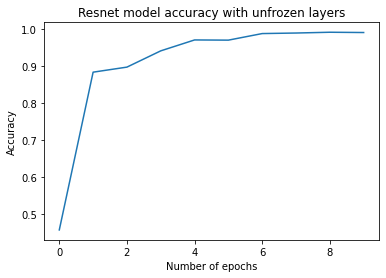

In [0]:
plt.plot(unfrozen_resnet_history.history['accuracy'])
plt.title("Resnet model accuracy with unfrozen layers")
plt.xlabel('Number of epochs')
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

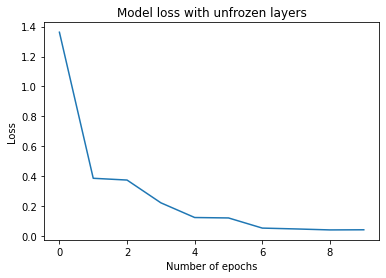

In [0]:
plt.plot(unfrozen_resnet_history.history['loss'])
plt.title("Model loss with unfrozen layers")
plt.xlabel('Number of epochs')
plt.ylabel("Loss")

In [0]:
frozen_resnet_model = ResNet50(include_top =True,weights='imagenet', input_shape=(224,224,3))
frozen_resnet_output= Flatten()(frozen_resnet_model.outputs[-1])
# resnet_output = Dense(10, activation = 'softmax')(resnet_flatten)
frozen_resnet_model = Model(inputs=frozen_resnet_model.inputs,outputs=frozen_resnet_output)
for layers in frozen_resnet_model.layers:
  layers.trainable = False
frozen_resnet_edited = tf.keras.Sequential()
frozen_resnet_edited.add(frozen_resnet_model)
frozen_resnet_edited.add(Dense(4096, activation='relu'))
frozen_resnet_edited.add(tf.keras.layers.Dropout(0.3))
frozen_resnet_edited.add(Dense(4096, activation='relu'))
frozen_resnet_edited.add(tf.keras.layers.Dropout(0.3))
frozen_resnet_edited.add(Dense(10, activation='softmax'))

In [0]:
train = full_ds_s.map(Resnet_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train = train.prefetch(tf.data.experimental.AUTOTUNE)

frozen_resnet_edited.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
frozen_resnet_history = frozen_resnet_edited.fit(train, epochs=10)

Epoch 1/10
701/701 [==============================] - 99s 141ms/step - loss: 2.1721 - accuracy: 0.1911
Epoch 2/10
701/701 [==============================] - 98s 139ms/step - loss: 2.0233 - accuracy: 0.2525
Epoch 3/10
701/701 [==============================] - 98s 140ms/step - loss: 1.9299 - accuracy: 0.2945
Epoch 4/10
701/701 [==============================] - 97s 139ms/step - loss: 1.8583 - accuracy: 0.3206
Epoch 5/10
701/701 [==============================] - 97s 138ms/step - loss: 1.8113 - accuracy: 0.3411
Epoch 6/10
701/701 [==============================] - 97s 138ms/step - loss: 1.7597 - accuracy: 0.3665
Epoch 7/10
701/701 [==============================] - 97s 138ms/step - loss: 1.7203 - accuracy: 0.3775
Epoch 8/10
701/701 [==============================] - 96s 138ms/step - loss: 1.6783 - accuracy: 0.3939
Epoch 9/10
701/701 [==============================] - 97s 139ms/step - loss: 1.6384 - accuracy: 0.4109
Epoch 10/10
701/701 [==============================] - 97s 138ms/step - l

In [0]:
frozen_resnet_history.history

{'accuracy': [0.1911344975233078,
  0.2524527311325073,
  0.29446128010749817,
  0.32059401273727417,
  0.3411077558994293,
  0.36648234724998474,
  0.3774527311325073,
  0.393863707780838,
  0.41085442900657654,
  0.42088833451271057],
 'loss': [2.1721034049987793,
  2.0233311653137207,
  1.9299473762512207,
  1.8582597970962524,
  1.8112982511520386,
  1.7597224712371826,
  1.7202528715133667,
  1.6783212423324585,
  1.6383651494979858,
  1.6121286153793335]}

### Results


Text(0, 0.5, 'Accuracy')

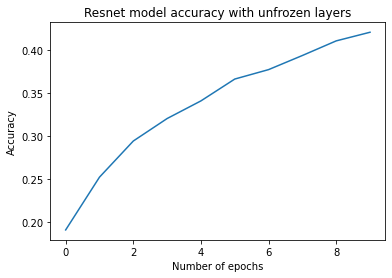

In [0]:
plt.plot(frozen_resnet_history.history['accuracy'])
plt.title("Resnet model accuracy with unfrozen layers")
plt.xlabel('Number of epochs')
plt.ylabel("Accuracy")

Text(0, 0.5, 'Loss')

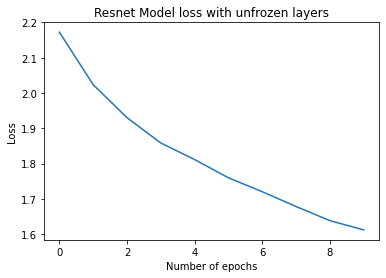

In [0]:
plt.plot(frozen_resnet_history.history['loss'])
plt.title("Resnet Model loss with unfrozen layers")
plt.xlabel('Number of epochs')
plt.ylabel("Loss")

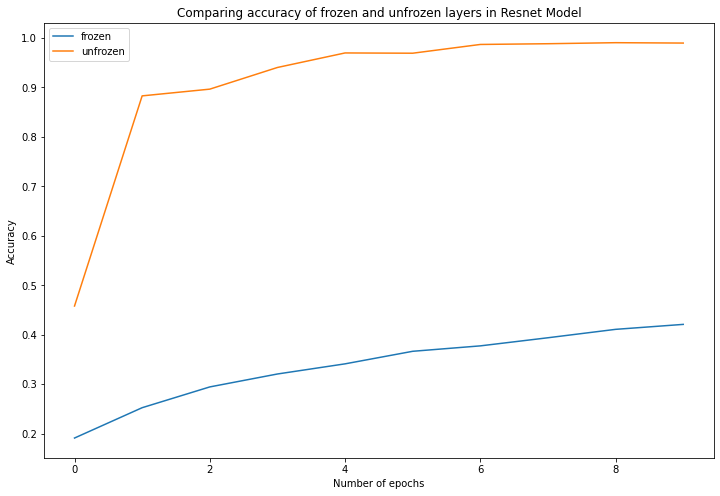

In [0]:
plt.figure(figsize=(12,8))
plt.plot(frozen_resnet_history.history['accuracy'])
plt.plot(unfrozen_resnet_history.history['accuracy'])
plt.title("Comparing accuracy of frozen and unfrozen layers in Resnet Model")
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend(['frozen','unfrozen'], loc='upper left')

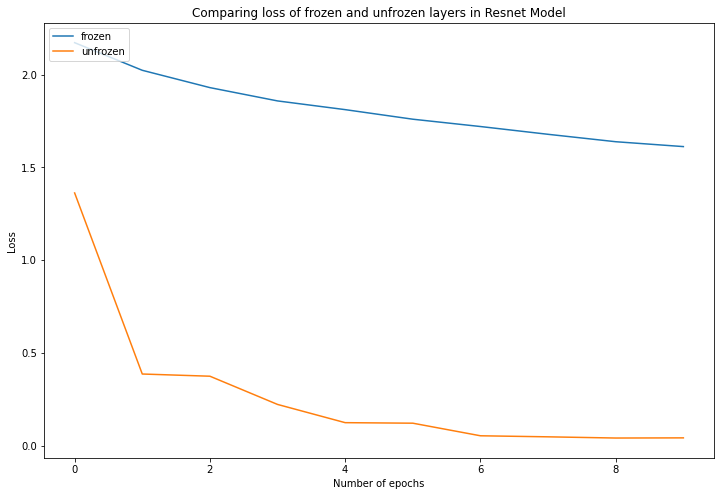

In [0]:
plt.figure(figsize=(12,8))
plt.plot(frozen_resnet_history.history['loss'])
plt.plot(unfrozen_resnet_history.history['loss'])
plt.title("Comparing loss of frozen and unfrozen layers in Resnet Model")
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(['frozen','unfrozen'], loc='upper left')

In [0]:
resnet_edited.save("drive/My Drive/unfrozen_resnet50_model.h5")

##Inception

###Summary

In [0]:
inception_model = InceptionV3(include_top = False,weights='imagenet', input_shape=(224,224,3),pooling='max')
inception_flatten = Flatten()(inception_model.outputs[-1])
# inception_output = Dense(10, activation = 'softmax')(inception_flatten)
inception_model = Model(inputs=inception_model.inputs,outputs=inception_flatten)
inception_edited = tf.keras.Sequential()
inception_edited.add(inception_model)
inception_edited.add(Dense(4096, activation='relu'))
inception_edited.add(tf.keras.layers.Dropout(0.3))
inception_edited.add(Dense(4096, activation='relu'))
inception_edited.add(tf.keras.layers.Dropout(0.3))
inception_edited.add(Dense(10, activation='softmax'))
inception_edited.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_29 (Functional)   (None, 2048)              21802784  
_________________________________________________________________
dense_40 (Dense)             (None, 4096)              8392704   
_________________________________________________________________
dropout_26 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_41 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dropout_27 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 10)                40970     
Total params: 47,017,770
Trainable params: 46,983,338
Non-trainable params: 34,432
____________________________________

In [0]:
frozen_inception_model = InceptionV3(include_top = False,weights='imagenet', input_shape=(224,224,3),pooling='max')
frozen_inception_flatten = Flatten()(frozen_inception_model.outputs[-1])
for layers in frozen_inception_model.layers:
  layers.trainable = False
frozen_inception_model = Model(inputs=frozen_inception_model.inputs,outputs=frozen_inception_flatten)
frozen_inception_edited = tf.keras.Sequential()
frozen_inception_edited.add(frozen_inception_model)
frozen_inception_edited.add(Dense(4096, activation='relu'))
frozen_inception_edited.add(tf.keras.layers.Dropout(0.3))
frozen_inception_edited.add(Dense(4096, activation='relu'))
frozen_inception_edited.add(tf.keras.layers.Dropout(0.3))
frozen_inception_edited.add(Dense(10, activation='softmax'))
frozen_inception_edited.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_33 (Functional)   (None, 2048)              21802784  
_________________________________________________________________
dense_46 (Dense)             (None, 4096)              8392704   
_________________________________________________________________
dropout_30 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_47 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dropout_31 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 10)                40970     
Total params: 47,017,770
Trainable params: 25,214,986
Non-trainable params: 21,802,784
________________________________

###Testing

In [0]:
accuracies = []
losses = []

for i in range(len(cv_training_ds)):
  inception_model = InceptionV3(include_top =False,weights='imagenet', input_shape=(320,240,3))
  inception_flatten = Flatten()(inception_model.outputs[-1])
  inception_output = Dense(10, activation = 'softmax')(inception_flatten)
  inception_model = Model(inputs=inception_model.inputs,outputs=inception_output)

  inception_model.compile(optimizer='nadam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
  inception_model.fit(cv_training_ds[i], epochs=10, validation_data=cv_val_ds[i], callbacks=inception_callbacks)

  # Generate generalization metrics
  scores = inception_model.evaluate(cv_val_ds[i], verbose=0)
  accuracies.append(scores[1] * 100)
  losses.append(scores[0])

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracies)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {losses[i]} - Accuracy: {accuracies[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracies)} (+- {np.std(accuracies)})')
print(f'> Loss: {np.mean(losses)}')
print('------------------------------------------------------------------------')

In [0]:
def Inception_preprocess(image,score):
  image = keras.applications.inception_v3.preprocess_input(image)
  if score is None:
        return image
  else:
        return image, score
train = full_ds_s.map(Inception_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train = train.prefetch(tf.data.experimental.AUTOTUNE)

inception_edited.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
unfrozen_inception_history = inception_edited.fit(train, epochs=10)

Epoch 1/10
701/701 [==============================] - 105s 150ms/step - loss: 2.4473 - accuracy: 0.1075
Epoch 2/10
701/701 [==============================] - 105s 150ms/step - loss: 1.3380 - accuracy: 0.4410
Epoch 3/10
701/701 [==============================] - 105s 149ms/step - loss: 0.6734 - accuracy: 0.7711
Epoch 4/10
701/701 [==============================] - 105s 149ms/step - loss: 0.2396 - accuracy: 0.9368
Epoch 5/10
701/701 [==============================] - 105s 149ms/step - loss: 0.1454 - accuracy: 0.9641
Epoch 6/10
701/701 [==============================] - 105s 149ms/step - loss: 0.1242 - accuracy: 0.9703
Epoch 7/10
701/701 [==============================] - 105s 149ms/step - loss: 0.1867 - accuracy: 0.9603
Epoch 8/10
701/701 [==============================] - 105s 149ms/step - loss: 0.1693 - accuracy: 0.9604
Epoch 9/10
701/701 [==============================] - 105s 149ms/step - loss: 0.1118 - accuracy: 0.9757
Epoch 10/10
701/701 [==============================] - 104s 149m

In [0]:
unfrozen_inception_history.history

{'accuracy': [0.10751873254776001,
  0.44095611572265625,
  0.771093487739563,
  0.9367641806602478,
  0.9641009569168091,
  0.9703442454338074,
  0.9602658152580261,
  0.9603995680809021,
  0.9756956696510315,
  0.9842133522033691],
 'loss': [2.447340726852417,
  1.3379772901535034,
  0.6733539700508118,
  0.23962128162384033,
  0.14542421698570251,
  0.12419217079877853,
  0.18674160540103912,
  0.16928334534168243,
  0.11177205294370651,
  0.0670648142695427]}

In [0]:
train = full_ds_s.map(Inception_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train = train.prefetch(tf.data.experimental.AUTOTUNE)

frozen_inception_edited.compile(optimizer='adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])
frozen_inception_history = frozen_inception_edited.fit(train, epochs=10)

Epoch 1/10
701/701 [==============================] - 64s 91ms/step - loss: 2.0686 - accuracy: 0.4072
Epoch 2/10
701/701 [==============================] - 65s 93ms/step - loss: 1.3286 - accuracy: 0.5065
Epoch 3/10
701/701 [==============================] - 65s 93ms/step - loss: 1.3152 - accuracy: 0.5205
Epoch 4/10
701/701 [==============================] - 65s 93ms/step - loss: 1.2323 - accuracy: 0.5549
Epoch 5/10
701/701 [==============================] - 65s 93ms/step - loss: 1.1606 - accuracy: 0.5746
Epoch 6/10
701/701 [==============================] - 65s 92ms/step - loss: 1.2201 - accuracy: 0.5614
Epoch 7/10
701/701 [==============================] - 65s 93ms/step - loss: 1.3357 - accuracy: 0.5258
Epoch 8/10
701/701 [==============================] - 65s 92ms/step - loss: 1.4237 - accuracy: 0.4822
Epoch 9/10
701/701 [==============================] - 65s 93ms/step - loss: 1.3805 - accuracy: 0.5051
Epoch 10/10
701/701 [==============================] - 65s 92ms/step - loss: 1.348

In [0]:
frozen_inception_history.history

{'accuracy': [0.4072422385215759,
  0.506510853767395,
  0.5205137133598328,
  0.5548965334892273,
  0.5745629668235779,
  0.5613628029823303,
  0.5257759690284729,
  0.4822065532207489,
  0.5050838589668274,
  0.5206029415130615],
 'loss': [2.06860089302063,
  1.3286464214324951,
  1.315225601196289,
  1.2322593927383423,
  1.160560965538025,
  1.2200864553451538,
  1.335684061050415,
  1.4236747026443481,
  1.3804690837860107,
  1.3482717275619507]}

### Results

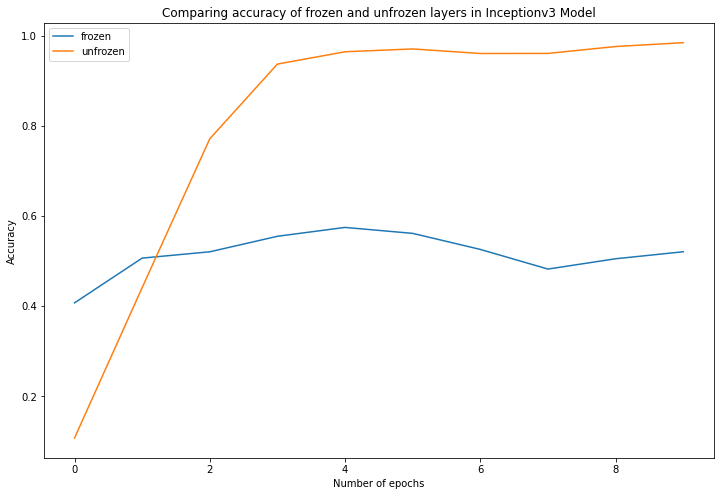

In [0]:
plt.figure(figsize=(12,8))
plt.plot(frozen_inception_history.history['accuracy'])
plt.plot(unfrozen_inception_history.history['accuracy'])
plt.title("Comparing accuracy of frozen and unfrozen layers in Inceptionv3 Model")
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend(['frozen','unfrozen'], loc='upper left')

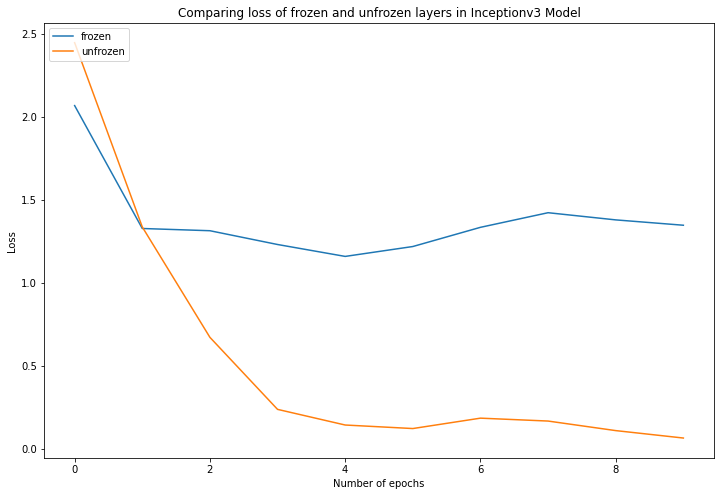

In [0]:
plt.figure(figsize=(12,8))
plt.plot(frozen_inception_history.history['loss'])
plt.plot(unfrozen_inception_history.history['loss'])
plt.title("Comparing loss of frozen and unfrozen layers in Inceptionv3 Model")
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend(['frozen','unfrozen'], loc='upper left')

In [0]:
inception_edited.save("drive/My Drive/unfrozen_inceptionv3_model.h5")

#Other

In [0]:
# it = iter(full_ds) # Dataset iterable
# images = next(it)[0].numpy() # Get first batch of images
# images = preprocess_input(images) # Preprocess images. Not sure if this necessary or not

# yhat = model.predict(images)